# Heuristic Search using Genetic Algorithm
## Completed by:   
* Denys Botuk

The main purporse of this work is to find an optimal air defense system deployment with respect to some specific characteristics of its combinations.

Having read some literature and papers I noticed that most of approaches are based on the discrete optimization.

The critical issue is to chose algorithm for solving this problem and objective function, based on which we will optimize our solution.

I've decided also observe the case of the discrete optimization. My approach is:
1. Separate the Ukraine territory into the grid of equal cells.
2. Calculate some characteristics per each cell, which will represent the risk of attack on this piece of territory.
3. Based on these characteristics find the best air defense deployment that minimizes the risk.

As any such characteristics is very sensitive information and we can't have an access to it, then given this, I catched an idea to consider the critical infrastructure objects, which belongs to the territory, represented by the specific cell. Thus, we prepared 'labeled_targets.json' file, which contains the information about the coordinates of objects and its critical value, which represents the "price" of its damage. These values are our subjective estimation, so it doesn't pretend to be realistic. We will call this characteristics as 'critical targets rate'.

Another charactestics could be the probability that air target would fly through the cell. For this purporse, we will generate a bug number of air attack simulations, and based on that data count such value per each cell.

So, solving of such type of the problem requires a bug amount of calculations per each cell. So, the performance time will depend on the number of cells.

Based on such idea, the first and obvious solution is to check all possible combinations and calculate possible risk rates for each case, but it would be very time consuming, and very depending on the grid size.

After reasearch of different types of scientific papers, I've made a decision to choose genetic algorithm for solving such problem. It's a good one for work on a large scale problems due to its flexibility, ability to work with complex, non-linear and multidimensional search spaces. It effectively works with combinatorial problems. 

The main idea behind this method is we start with various solutions, let the best ones 'survive', mix them to create new solutions, and iterate this process to evolve towards the best possible solution. This method is described in more details in the **GeneticOptimizer.ipynb** file, where the functionality of this algorithm is implemented and described.

In [1]:
import ipynb.fs.full.GeneticOptimizer as optimizer
import ipynb.fs.full.GridVisualizer as visualizer
import ipynb.fs.full.ProjectAPI as api
import json
import numpy as np
import seaborn as sns
import tqdm
import warnings

from copy import deepcopy
from matplotlib import pyplot as plt
from numpy.random import randint
from numpy.random import rand
from ipynb.fs.full.GridVisualizer import CriticalTarget

warnings.simplefilter(action='ignore', category=FutureWarning)

So, first of all we need to identify the objective function. As I mentioned previously, I propose to calculate it based on the some values per each cell of the map grid.

Now, let's define some functions, which will be useful for us on the further steps.

The next function checks if the specific air defense system, deployed at some place, covers a specific cell. As we have a grid of cells, but destruction range of the system is a circle, then we will consider that system covers the cell, if it covers each edge of this cell.

In [2]:
def covers_cell(ppo, cell):
    return ppo.is_in_destruction_range(cell.top_latitude, cell.left_longitude) & \
           ppo.is_in_destruction_range(cell.bottom_latitude, cell.left_longitude) & \
           ppo.is_in_destruction_range(cell.top_latitude, cell.right_longitude) & \
           ppo.is_in_destruction_range(cell.bottom_latitude, cell.right_longitude)

Then, formulate an objective function, which is called 'fitness' in the genetic algorithm and some additional helpful functions.

*calculate_critical_rate_around_ppo* function calculates the critical rate per each cell, which is covered by the air defense system by the following rule:
$$c_j = c_j \cdot (1 - p_i)$$
where $c_j$ is critical rate of the cell and $p_j$ is the probability of the system to destroy air target.

basically, we can calculate it, considering and checking each cell in a grid, but I propose the following approach to optimize the time execution of it, which actually is natural: given the cell, where system is deployed, for the first circle we check the straight neighbor cells, then neighbor on the diagonal , then if all the cells are covered, we go to the next circle of neighbors, until we come across the cell, which is not covered.

Such optimization saves $\sim 1$ minute of time execution for the grid with more than 100 cells. 

*recalculate_critical_rate* calls *calculate_critical_rate_around_ppo* for each cell, where system is deployed.

*fitness* is an objective function, which we will miniize during the optimization. It decodes the intermediate result of the optimization into the systems placement, and calls recalculation functions for the whole grid. After recalculation it calculates the sum of the critical rates per each cell in a grid. This sum will represent the risk, which we will try to minimize. Critical rates will be calculated based on the strategy, we choose.
$$\sum\limits_j c_j \cdot (1 - p_i) \rightarrow \min_i$$

In [3]:
def calculate_critical_rate_around_ppo(cells, ppo_i, ppo_j, shape):
    '''calculates the critical rate per each cell, which is covered by the air defense system'''
    radius = 1
    
    # False if any cell found that is not covered by the system
    calc = True
    
    while calc:
        
        # check and calculate critical rate for the straight neighbor cells
        if ppo_i  >= radius:
            if cells[ppo_i - radius][ppo_j]:
                if covers_cell(cells[ppo_i][ppo_j].ppo, cells[ppo_i - radius][ppo_j]):
                    cells[ppo_i - radius][ppo_j].critical_rate = cells[ppo_i - radius][ppo_j].critical_rate * (1 - cells[ppo_i][ppo_j].ppo.base_destruction_prob)
                else:
                    calc = False
        if ppo_i <= shape[0] - radius - 1:
            if cells[ppo_i + radius][ppo_j]:
                if covers_cell(cells[ppo_i][ppo_j].ppo, cells[ppo_i + radius][ppo_j]):
                    cells[ppo_i + radius][ppo_j].critical_rate = cells[ppo_i + radius][ppo_j].critical_rate * (1 - cells[ppo_i][ppo_j].ppo.base_destruction_prob)
                else:
                    calc = False
        if ppo_j >= radius:
            if cells[ppo_i][ppo_j - radius]:
                if covers_cell(cells[ppo_i][ppo_j].ppo, cells[ppo_i][ppo_j - radius]):
                    cells[ppo_i][ppo_j- radius].critical_rate = cells[ppo_i][ppo_j- radius].critical_rate * (1 - cells[ppo_i][ppo_j].ppo.base_destruction_prob)
                else:
                    calc = False
        if ppo_j <= shape[1] - radius - 1:
            if cells[ppo_i][ppo_j + radius]:
                if covers_cell(cells[ppo_i][ppo_j].ppo, cells[ppo_i][ppo_j + radius]):
                    cells[ppo_i][ppo_j + radius].critical_rate = cells[ppo_i][ppo_j + radius].critical_rate * (1 - cells[ppo_i][ppo_j].ppo.base_destruction_prob)
                else:
                    calc = False
                    
        # check and calculate critical rate for the neighbor cells on the diagonal
        if calc:
            if (ppo_i  >= radius) & (ppo_j  >= radius):
                if cells[ppo_i - radius][ppo_j - radius]:
                    if covers_cell(cells[ppo_i][ppo_j].ppo, cells[ppo_i - radius][ppo_j - radius]):
                        cells[ppo_i - radius][ppo_j - radius].critical_rate = cells[ppo_i - radius][ppo_j - radius].critical_rate * (1 - cells[ppo_i][ppo_j].ppo.base_destruction_prob)
            if (ppo_i  >= radius) & (ppo_j <= shape[1] - radius - 1):
                if cells[ppo_i - radius][ppo_j + radius]:
                    if covers_cell(cells[ppo_i][ppo_j].ppo, cells[ppo_i - radius][ppo_j + radius]):
                        cells[ppo_i - radius][ppo_j + radius].critical_rate = cells[ppo_i - radius][ppo_j + radius].critical_rate * (1 - cells[ppo_i][ppo_j].ppo.base_destruction_prob)
            if (ppo_i <= shape[0] - radius - 1) & (ppo_j  >= radius):
                if cells[ppo_i + radius][ppo_j - radius]:
                    if covers_cell(cells[ppo_i][ppo_j].ppo, cells[ppo_i + radius][ppo_j - radius]):
                        cells[ppo_i + radius][ppo_j - radius].critical_rate = cells[ppo_i + radius][ppo_j - radius].critical_rate * (1 - cells[ppo_i][ppo_j].ppo.base_destruction_prob)
            if (ppo_i <= shape[0] - radius - 1) & (ppo_j <= shape[1] - radius - 1):
                if cells[ppo_i + radius][ppo_j + radius]:
                    if covers_cell(cells[ppo_i][ppo_j].ppo, cells[ppo_i + radius][ppo_j + radius]):
                        cells[ppo_i + radius][ppo_j + radius].critical_rate = cells[ppo_i + radius][ppo_j + radius].critical_rate * (1 - cells[ppo_i][ppo_j].ppo.base_destruction_prob)
        radius += 1
        

def recalculate_critical_rate(cells, shape):
    '''calculates the critical rate per each neighbors of the cell, where system is deployed'''
    for i in range(len(cells)):
        for j in range(len(cells[i])):
            if cells[i][j]:
                if cells[i][j].ppo:
                    # given the cell with deployed system recalculate critical rate for neighbors
                    cells[i][j].critical_rate = cells[i][j].critical_rate * (1 - cells[i][j].ppo.base_destruction_prob)
                    calculate_critical_rate_around_ppo(cells, i, j, shape)
        
        
def fitness(combination, systems, cells, shape):
    '''decodes given combination into the system placement and recalculates critical rates of the grid'''
    systems_copy = deepcopy(systems)
    grid_copy = deepcopy(cells)
    placement_cells = None
    for name in systems.keys():
        # decodes the combination into systems placement
        placement_cells = grid_copy[grid_copy != None][combination == optimizer.get_ppo_index(name)]
        ppo = systems_copy[name]
        for i in range(len(ppo)):
            # set air defense system into the cell
            ppo[i].coords = (placement_cells[i].center_latitude, placement_cells[i].center_longitude)
            placement_cells[i].ppo = ppo[i]
    
    # recalculate critical values on the grid
    recalculate_critical_rate(grid_copy.reshape(shape), shape)
    
    # calculate the total risk
    return sum(cell.critical_rate for cell in grid_copy if cell)

The following functions will be used for the launching of the optimal system placement after algorithm execution.

In [4]:
def get_positions_for_ppo(name, ppo_positions, cells, strategy):
    '''retrieves positions of the defense systems for the specific type'''
    return cells[cells != None][ppo_positions == optimizer.get_ppo_index(name)]

def launch_anti_air_systems(systems, ppo_positions, cells, strategy):
    '''deplot defense system onto the optimal placement and write these coordinates into file'''
    systems_json = {}
    for ppo in systems.keys():
        # get positions of the system for the specific type
        ppo_cells = get_positions_for_ppo(ppo, ppo_positions, cells, strategy)
        for i in range(len(systems[ppo])):
            # set the coordinates into the system
            coords = (ppo_cells[i].center_latitude, ppo_cells[i].center_longitude)
            systems[ppo][i].coords = coords
            systems_json[f"{ppo}_{i}"] = coords
    with open(f'{strategy}/anti_air_systems.json', 'w') as f:
        json.dump(systems_json, f, indent=4)
    return systems

As I mentioned before, I will need a huge amount of simularions for calculation of the flight rate per each cell.

In [5]:
# api.start_attac(1000, 1000, 1000, 1000, 1000, 1000);
# api.visualisation();

For calculation 'critical targets rate' we need the data about targets placement and its critical rate. Let's retrieve it:

In [6]:
targets = visualizer.end_points()
target_data = list()
for key in targets.keys():
    for target in targets[key]:
        target_data.append(CriticalTarget(key, target['latitude'], target['longitude'], target['critical_rate']))

sim_data = visualizer.flight_data()

To have measurable results we will train and test on the following set of the defense systems for all of the strategies and cases

In [7]:
ppo_set = { 
            'S300':1, 
            'Buk':4, 
            'StormerHMV':0, 
            'Hawk':3, 
            'Spada':0, 
            'SAMPT':2, 
            'NASAMS':0, 
            'Patriot':2, 
            'IRIST':0, 
            'Crotale':0 
          }

Let's read all of the default characteristics of the systems, prepared earlier by our teammate.

In [8]:
systems = {}
for name, count in ppo_set.items():
    systems[name] = list()
    for i in range(count):
        systems[name].append(api.PPOSystem(name, (0,0), *api.ppo_characteristics[name]))

As I mentioned before, I will use genetic algorithm for finding optimal placement of the air defense systems.

This algorithm depends on some parameters:
* crossover rate - probability, if crossover between two parent individuals will be performed or not.
* mutation rate - probability, if mutation inside the individual chromosome will be performed or not.
* combination length - which actually is the number of cells
* population number - number of individuals inside the population
* iteration number - number of the iterations, we execute algorithm on the population data

Each of this parameters influence the result a lot.
During some testing and investigating the results and literature research, I decided to set :
* crossover rate = 0.9
* mutation rate = $\frac{1}{combination length}$
* combination length = number of the cells (optimal one is the number of the cells, which has the diagonal equal to the smallest diameter of destruction range of the systems, as we consider only strategic systems, so we will test only on those systems, that has destruction range $\geq 100$ km)
* population number = 500 (it will check more possible variants, so the results will be closer to the optimum)
* iteration number = 50 (execute the algorithm 50 times to get the best solution, as we can)

I decided to check the work of algorithm on the different strategies:
* strategy 1: deployment along the most popular routes
* strategy 2: deployment along the most valuable targets
* strategy 3: combination of 1st and 2nd

Each of the strategies we will estimate by two metrics:
* accuracy - the percentage of the destructed air targets
* total damage - total damage per each targets, reached by air targets

Each solution we will test on $50$ simulations and take an average metrices.

# Strategy 1: Deployment along the most popular routes

Using this strategy, we take into account only the percentage of the air targets, that passed through the cell, given the simulated data. So, objective function will be:
$$\sum\limits_j f_j \cdot (1 - p_i) \rightarrow \min_i$$
where $f_j$ - flight rate and $p_i$ - probability of the system to destroy the air target.

So, let's create a grid of cells, and calculate flight rate for each of them.

In [9]:
strategy = 'route'
grid, grid_shape = visualizer.makeGrid(200 / np.sqrt(2), strategy)
for cell in grid:
    if cell:
        cell.calculate_critical_rate(sim_data, target_data)

visualizer.grid_visualisation(grid, strategy)

cells_count = len(grid[grid != None])
print(f"Created grid with {cells_count} cells")

Created grid with 37 cells


Then let's find an optimal system placement, based on this strategy.

In [10]:
ppo_names = list(api.ppo_characteristics.keys())
# define the total iterations
n_iter = 50
# bits
n_bits = len(grid[grid != None])
# define the population size
n_pop = 500
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 1.0 / float(n_bits)
# ppo count
ppo_count = len(systems)
# perform the genetic algorithm search
route_best, route_score = optimizer.genetic_algorithm(fitness, ppo_set, systems, grid, grid_shape, n_bits, n_iter, n_pop, r_cross, r_mut)
print('f(%s) = %f' % (route_best, route_score))

100%|███████████████████████████████████████████| 50/50 [07:14<00:00,  8.69s/it]

f([0 6 2 0 0 4 0 4 0 0 6 0 8 0 4 2 2 0 0 8 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0]) = 100.259000


Given the solution, let's set the system into the cells.

In [11]:
launch_anti_air_systems(systems, route_best, grid, strategy)
api.ppo_visualisation(strategy)

And now, let's calculate metrices for the solution estimation, based on the $50$ simulations of an air attack.

In [12]:
route_accuracy_scores = list()
route_critical_scores = list()
iters = 50
for i in tqdm.tqdm(range(iters)):
    api.start_attac(100, 25, 25, 25, 25, 25)
    accuracy, critical = api.simulate_defence(i, strategy)
    route_accuracy_scores.append(accuracy)
    route_critical_scores.append(critical)
print(f"An average accuracy score is: {np.mean(route_accuracy_scores)}")
print(f"An average total critical score is: {np.mean(route_critical_scores)}")

100%|███████████████████████████████████████████| 50/50 [03:25<00:00,  4.12s/it]

An average accuracy score is: 0.778
An average total critical score is: 1310.7


Now, visualize recieved metrices.

Text(0, 0.5, 'frequency')

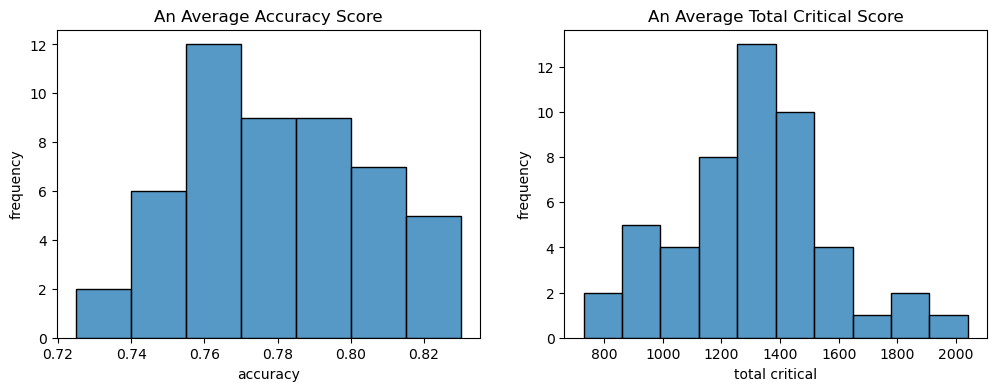

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(route_accuracy_scores)
plt.title('An Average Accuracy Score')
plt.xlabel('accuracy')
plt.ylabel('frequency')

plt.subplot(1, 2, 2);
sns.histplot(route_critical_scores)
plt.title('An Average Total Critical Score')
plt.xlabel('total critical')
plt.ylabel('frequency')

So, here we can see, that an average accuracy score is: 77.8\% of destructed air targets, which is pretty good.

Range of accuracy using such strategy is 72-83\%.

An average total critical score is: 1310.7 of total damage.

Range of damage is 800-2000.

Let's switch to another strategy and execute the same steps.

# Strategy 2: Deployment along the most valuable targets

Using this strategy, we take into account only the critical targets rates of the critical targets, which belong to the cell. So, objective function will be:
$$\sum\limits_j ct_j \cdot (1 - p_i) \rightarrow \min_i$$
where $ct_j$ - critical targets rate and $p_i$ - probability of the system to destroy the air target.

In [30]:
strategy = 'critical'
grid, grid_shape = visualizer.makeGrid(200 / np.sqrt(2), strategy)
for cell in grid:
    if cell:
        cell.calculate_critical_rate(sim_data, target_data)

visualizer.grid_visualisation(grid, strategy)

cells_count = len(grid[grid != None])
print(f"Created grid with {cells_count} cells")

Created grid with 37 cells


In [31]:
ppo_names = list(api.ppo_characteristics.keys())
# define the total iterations
n_iter = 50
# bits
n_bits = len(grid[grid != None])
# define the population size
n_pop = 500
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 1.0 / float(n_bits)
# ppo count
ppo_count = len(systems)
# perform the genetic algorithm search
critical_best, critical_score = optimizer.genetic_algorithm(fitness, ppo_set, systems, grid, grid_shape, n_bits, n_iter, n_pop, r_cross, r_mut)
print('f(%s) = %f' % (critical_best, critical_score))

100%|███████████████████████████████████████████| 50/50 [09:28<00:00, 11.37s/it]

f([0 0 8 0 1 8 0 0 4 0 0 0 0 2 2 0 0 0 2 4 0 0 0 0 6 0 0 0 0 6 0 0 0 2 0 0 4]) = 35.183796


In [32]:
launch_anti_air_systems(systems, critical_best, grid, strategy)
api.ppo_visualisation(strategy)

In [33]:
critical_accuracy_scores = list()
critical_critical_scores = list()
iters = 50
for i in tqdm.tqdm(range(iters)):
    api.start_attac(100, 25, 25, 25, 25, 25)
    accuracy, critical = api.simulate_defence(i, strategy)
    critical_accuracy_scores.append(accuracy)
    critical_critical_scores.append(critical)
print(f"An average accuracy score is: {np.mean(critical_accuracy_scores)}")
print(f"An average total critical score is: {np.mean(critical_critical_scores)}")

100%|███████████████████████████████████████████| 50/50 [04:33<00:00,  5.48s/it]

An average accuracy score is: 0.7663
An average total critical score is: 1279.9


Text(0, 0.5, 'frequency')

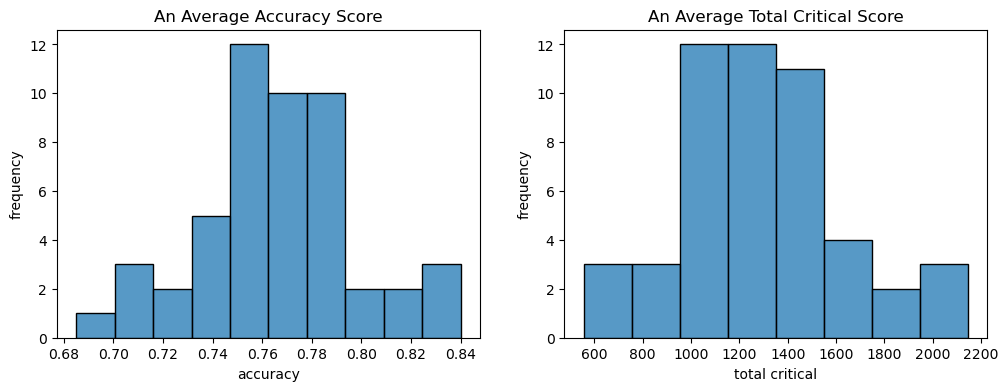

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(critical_accuracy_scores)
plt.title('An Average Accuracy Score')
plt.xlabel('accuracy')
plt.ylabel('frequency')

plt.subplot(1, 2, 2);
sns.histplot(critical_critical_scores)
plt.title('An Average Total Critical Score')
plt.xlabel('total critical')
plt.ylabel('frequency')

So, here we have very similar result:

An average accuracy score is: 76.63\% of destructed air targets.

Range of accuracy using such strategy is 68-84\%.

An average total critical score is: 1279.9 of total damage.

Range of damage is 600-2100.

So, accuracy is a little bit lower than for previous strategy, and total critical score is also a little bit lower. Also, we can notice that the ranges for both matrices are wider than previously.

Now, consider the combination of these strategies.

# Strategy 3: Combination strategy

Using this strategy, we take into account both flight rate and critical targets rate. So, objective function will be:
$$\sum\limits_j (f_j + ct_j) \cdot (1 - p_i) \rightarrow \min_i$$

So, let's create a grid of cells, and calculate combined rate for each of them.

In [35]:
strategy = 'combination'
grid, grid_shape = visualizer.makeGrid(200 / np.sqrt(2), strategy)
for cell in grid:
    if cell:
        cell.calculate_critical_rate(sim_data, target_data)

visualizer.grid_visualisation(grid, strategy)

cells_count = len(grid[grid != None])
print(f"Created grid with {cells_count} cells")

Created grid with 37 cells


In [36]:
ppo_names = list(api.ppo_characteristics.keys())
# define the total iterations
n_iter = 50
# bits
n_bits = len(grid[grid != None])
# define the population size
n_pop = 500
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 1.0 / float(n_bits)
# ppo count
ppo_count = len(systems)
# perform the genetic algorithm search
combination_best, combination_score = optimizer.genetic_algorithm(fitness, ppo_set, systems, grid, grid_shape, n_bits, n_iter, n_pop, r_cross, r_mut)
print('f(%s) = %f' % (combination_best, combination_score))

100%|███████████████████████████████████████████| 50/50 [09:28<00:00, 11.38s/it]

f([0 2 4 0 0 0 8 0 0 0 0 0 0 2 0 0 0 0 0 0 2 4 6 0 0 0 6 0 0 8 0 4 2 0 0 1 0]) = 142.449124


In [37]:
launch_anti_air_systems(systems, combination_best, grid, strategy)
api.ppo_visualisation(strategy)

In [38]:
combination_accuracy_scores = list()
combination_critical_scores = list()
iters = 50
for i in tqdm.tqdm(range(iters)):
    api.start_attac(100, 25, 25, 25, 25, 25)
    accuracy, critical = api.simulate_defence(i, strategy)
    combination_accuracy_scores.append(accuracy)
    combination_critical_scores.append(critical)
print(f"An average accuracy score is: {np.mean(combination_accuracy_scores)}")
print(f"An average total critical score is: {np.mean(combination_critical_scores)}")

100%|███████████████████████████████████████████| 50/50 [04:25<00:00,  5.31s/it]

An average accuracy score is: 0.8346000000000001
An average total critical score is: 856.6


Text(0, 0.5, 'frequency')

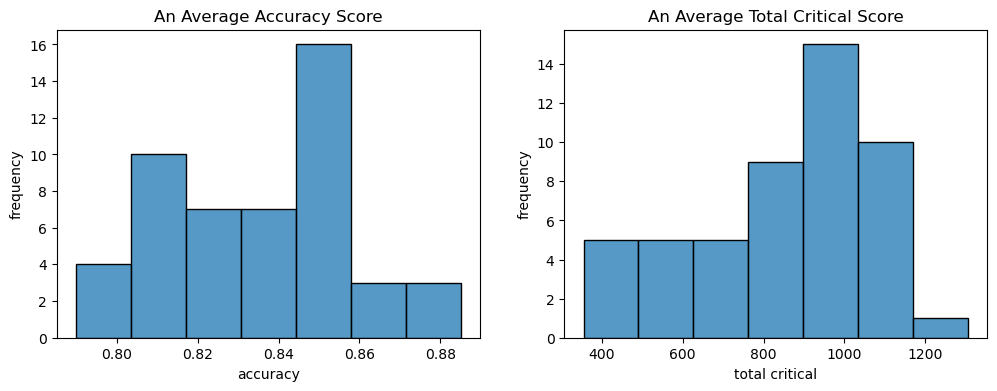

In [39]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(combination_accuracy_scores)
plt.title('An Average Accuracy Score')
plt.xlabel('accuracy')
plt.ylabel('frequency')

plt.subplot(1, 2, 2);
sns.histplot(combination_critical_scores)
plt.title('An Average Total Critical Score')
plt.xlabel('total critical')
plt.ylabel('frequency')

So, here we have significantly better results:

An average accuracy score is: 83.46\% of destructed air targets.

Range of accuracy using such strategy is 79-89\%.

An average total critical score is: 856.6 of total damage.

Range of damage is 400-1200.

So, “the best strategy” is the combination of the first and second ones. So, it takes into account both data from simulated routes of the air targets and damage rates of the potential targets. The first one is similar to the second one, but we can notice that the range of the result of the second strategy is wider.

Also, we should take into account that this algorithm is heuristic one. So, it produces different solutions each time, but in general these solutions converges approximately into the same range - $\sim 72-87\%$.

So, this algorithm is a good one to use, but we should consider that it includes a few parameters, in particular, probabilistic, that can have a big impact on the produced results. As well as parameters, the construction of the objective function also influence a lot. As we saw from the result, when we take into account combined risk rate, we get better results, so the more realistic is objective function, the better solutions algorithm will provide.

In conclusion, I would stress the following advantages of the genetic algorithm in solving of the discrete optimization problem:
* Good at Exploring Complex Search Spaces: can efficiently search through complex and high-dimensional spaces. It is particularly adept at finding good solutions in problems where the landscape is rugged or has many local optima.
* Robust and Flexible: does not make many assumptions about the problem being solved, making them robust and applicable to a wide range of problems, including those with nonlinear and complex relationships.
* Adaptability: can be adapted to handle multiple objectives, which is common in real-world problems like air defense system deployment where factors like effectiveness, cost, and coverage area might need to be balanced.
* Handling Discrete Variables: is particularly suited for discrete optimization problems, making it ideal for scenarios where decisions are categorical.

Disadvantages and risks are:
* Computationally Intensive: can be computationally expensive, especially as the size of the problem increases. The need to evaluate a large population of solutions over many generations can demand significant computational resources.
* Tuning of Parameters: requires careful tuning of parameters such as population size, mutation rate, and crossover rate. The performance of the algorithm can be highly sensitive to these settings, and finding the right balance can be challenging and time-consuming.
* No Guarantee of Optimal Solution: GAs can typically find good solutions, but they do not guarantee that the solution is globally optimal. This is a common trait among heuristic algorithms.
* Domain Knowledge Required for Fitness Function: Designing an effective fitness function (to evaluate and select the best candidates) often requires deep domain knowledge. In the context of air defense, this means a comprehensive understanding of strategic, operational, and tactical considerations.

Improvement steps:
if we think, what could be modified to improve the effiency of this approach, I would point out the following:
* transformation intp continious optimization, but for this we need also modify the map ranking, it could something like heatmap based on some data
* we can investigate the domain and find some more charactestics to optimize the solution by.
* do some effective analysis of algorithm's hyperparameters impact and propose the optimal set, based on some metrices and results.